In [1]:
# 0. 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping, Callback
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle

In [2]:
# 1. 데이터 불러오기 및 기본 전처리
df = pd.read_csv("./Data/Dummy02_ver01.csv")

# event_time 컬럼을 datetime 형식으로 변환
df['event_time'] = pd.to_datetime(df['event_time'])

# epc_code, product_serial, event_time 순으로 정렬 (각 제품별 이벤트 순서를 보장)
df = df.sort_values(by=['epc_code', 'product_serial', 'event_time'])
print("데이터 샘플:")
display(df.head(10))

데이터 샘플:


,epc_code,product_serial,product_name,hub_type,event_type,event_time
0,001.8805843.584374.000000001,1,Product 1,Yeongju,commissioning,2025-01-21 17:54:00
1,001.8805843.584374.000000001,1,Product 1,Yeongju,aggregation,2025-01-21 18:15:00
2,001.8805843.584374.000000001,1,Product 1,Yeongju,WMS_inbound,2025-01-21 18:55:00
3,001.8805843.584374.000000001,1,Product 1,Yeongju,WMS_outbound,2025-01-25 07:35:00
4,001.8805843.584374.000000001,1,Product 1,Busan_yangsan,stock_inbound(HUB),2025-01-25 10:51:00
5,001.8805843.584374.000000001,1,Product 1,Busan_yangsan,stock_outbound(HUB),2025-03-02 04:15:00
6,001.8805843.584374.000000001,1,Product 1,Busan_dongnea,stock_inbound(Wholesaler),2025-03-02 12:21:00
7,001.8805843.584374.000000001,1,Product 1,Busan_dongnea,stock_outbound(Wholesaler),2025-03-28 03:16:00
8,001.8805843.584374.000000001,1,Product 1,Busan_gumjung,stock_inbound(Reseller),2025-03-28 07:33:00
9,001.8805843.584374.000000001,1,Product 1,Busan_gumjung,stock_outbound(Sell),2025-04-17 14:25:00


In [3]:
# 2. 시간 정보 처리: 각 제품별 첫 이벤트를 기준으로한 시간 차이(time_delta) 생성
# (각 이벤트가 첫 이벤트 이후 몇 초 후에 발생했는지를 수치화)
df['time_delta'] = df.groupby(['epc_code', 'product_serial'])['event_time'] \
                      .transform(lambda x: (x - x.min()).dt.total_seconds())

In [4]:
# 3. 변수 인코딩: event_type과 hub_type
# 이벤트 종류(event_type) 인코딩
le_event = LabelEncoder()
df['event_type_enc'] = le_event.fit_transform(df['event_type'])

# 허브 타입(hub_type) 인코딩
le_hub = LabelEncoder()
df['hub_type_enc'] = le_hub.fit_transform(df['hub_type'])

# 수치형 변수 정규화: 시간 차이(time_delta)를 [0,1] 범위로 스케일링
scaler = MinMaxScaler()
df['time_delta_scaled'] = scaler.fit_transform(df[['time_delta']])

# 확인
print("전처리 후 데이터 샘플:")
display(df[['epc_code', 'product_serial', 'event_time', 'time_delta', 
          'event_type', 'event_type_enc', 'hub_type', 'hub_type_enc', 'time_delta_scaled']].head(10))

전처리 후 데이터 샘플:


,epc_code,product_serial,event_time,time_delta,event_type,event_type_enc,hub_type,hub_type_enc,time_delta_scaled
0,001.8805843.584374.000000001,1,2025-01-21 17:54:00,0.0,commissioning,3,Yeongju,15,0.000000
1,001.8805843.584374.000000001,1,2025-01-21 18:15:00,1260.0,aggregation,2,Yeongju,15,0.000105
2,001.8805843.584374.000000001,1,2025-01-21 18:55:00,3660.0,WMS_inbound,0,Yeongju,15,0.000304
3,001.8805843.584374.000000001,1,2025-01-25 07:35:00,308460.0,WMS_outbound,1,Yeongju,15,0.025655
4,001.8805843.584374.000000001,1,2025-01-25 10:51:00,320220.0,stock_inbound(HUB),4,Busan_yangsan,2,0.026633
5,001.8805843.584374.000000001,1,2025-03-02 04:15:00,3406860.0,stock_outbound(HUB),7,Busan_yangsan,2,0.283357
6,001.8805843.584374.000000001,1,2025-03-02 12:21:00,3436020.0,stock_inbound(Wholesaler),6,Busan_dongnea,0,0.285782
7,001.8805843.584374.000000001,1,2025-03-28 03:16:00,5649720.0,stock_outbound(Wholesaler),9,Busan_dongnea,0,0.469901
8,001.8805843.584374.000000001,1,2025-03-28 07:33:00,5665140.0,stock_inbound(Reseller),5,Busan_gumjung,1,0.471183
9,001.8805843.584374.000000001,1,2025-04-17 14:25:00,7417860.0,stock_outbound(Sell),8,Busan_gumjung,1,0.616961


In [5]:
# 4. 시퀀스 데이터 구성
# 각 제품(또는 epc_code, product_serial 단위)의 이벤트 시퀀스를 구성합니다.
# 사용할 피처: event_type_enc, hub_type_enc, time_delta_scaled
feature_columns = ['event_type_enc', 'hub_type_enc', 'time_delta_scaled']
max_seq_length = 10  # 각 시퀀스의 최대 길이 (필요에 따라 조정)

def create_sequence(group, max_seq_length, feature_columns):
    
    #그룹별(제품별) 데이터를 입력받아, feature_columns에 해당하는 시퀀스 데이터를 생성합니다.
    #시퀀스 길이가 max_seq_length보다 짧으면 0으로 패딩합니다.
    
    # 해당 그룹의 데이터를 시간 순으로 정렬된 상태에서 feature_columns 추출
    seq = group[feature_columns].values
    
    # 시퀀스 길이가 max_seq_length보다 작으면 패딩 (뒤쪽에 0으로 채움)
    if len(seq) < max_seq_length:
        padding = np.zeros((max_seq_length - len(seq), len(feature_columns)))
        seq = np.vstack([seq, padding])
    else:
        seq = seq[:max_seq_length]
    return seq

# 각 제품별 그룹으로 시퀀스 구성
grouped = df.groupby(['epc_code', 'product_serial'])
sequences = grouped.apply(lambda x: create_sequence(x, max_seq_length, feature_columns))

# sequences는 pandas Series 형태이므로 numpy array로 변환
X = np.stack(sequences.values)
print("구성된 시퀀스 데이터 shape:", X.shape)  
# 결과 shape 예시: (제품 수, max_seq_length, feature 개수)

구성된 시퀀스 데이터 shape: (11103, 10, 3)


C:\Users\user\AppData\Local\Temp\ipykernel_15976\447252473.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sequences = grouped.apply(lambda x: create_sequence(x, max_seq_length, feature_columns))


In [6]:
# 5. LSTM Autoencoder 모델 구성
# 입력 데이터 shape: (timesteps, input_dim)
input_dim = X.shape[2]    # feature 수
timesteps = X.shape[1]    # 시퀀스 길이
latent_dim = 64           # 잠재 공간 차원 (조정 가능)

# 모델 구성
inputs = Input(shape=(timesteps, input_dim))

# 인코더: LSTM을 사용하여 시퀀스를 잠재 벡터로 인코딩
encoded = LSTM(latent_dim, activation='tanh')(inputs)

# 디코더: RepeatVector와 LSTM을 사용하여 시퀀스를 재구성
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)

# Autoencoder 모델 정의 및 컴파일
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='Adam', loss='mse') # Adam -> RMSprop 변경, mse -> mae 변경
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 3)          │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 3)          │            12 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,236 (71.23 KB)

 Trainable params: 18,236 (71.23 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 6. 커스텀 콜백: 매 에포크마다 현재 모델로 예측한 재구성 오차를 기준으로
#    (재구성 오차의 평균 + 3×표준편차)를 임계치로 하여, 초과하는 샘플의 개수를 계산
class AnomalyCountCallback(Callback):
    def __init__(self, training_data):
        super().__init__()
        self.training_data = training_data
        self.epoch_anomaly_counts = []
    
    def on_epoch_end(self, epoch, logs=None):
        X_pred = self.model.predict(self.training_data, verbose=0)
        
        # 각 샘플별 재구성 오차
        reconstruction_errors = np.mean(np.square(X_pred - self.training_data), axis=(1,2))
        
        # 현재 에포크의 임계치: 평균 + 3 * 표준편차
        threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
        anomaly_count = np.sum(reconstruction_errors > threshold)
        self.epoch_anomaly_counts.append(anomaly_count)

Epoch 1/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 46.3180 - val_loss: 38.2567
Epoch 2/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 36.2535 - val_loss: 30.7507
Epoch 3/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 29.2236 - val_loss: 25.4831
Epoch 4/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 24.2901 - val_loss: 21.6891
Epoch 5/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 20.7938 - val_loss: 18.9119
Epoch 6/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 18.2316 - val_loss: 16.8637
Epoch 7/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 16.2382 - val_loss: 15.3821
Epoch 8/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 14.9734 - val_loss: 14.3285
Epoch 9/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 14.0148 - val_loss: 13.6101
Epoch 10/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 13.3067 - val_loss: 13.1459
Epoch 11/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 12.8392 - val_loss: 12.8644
Epoch 12/100
278/2

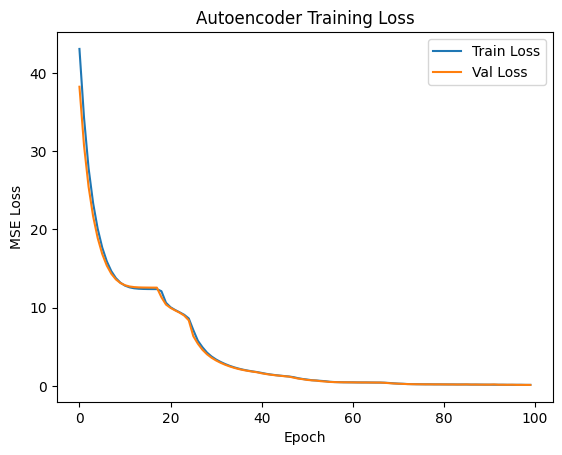

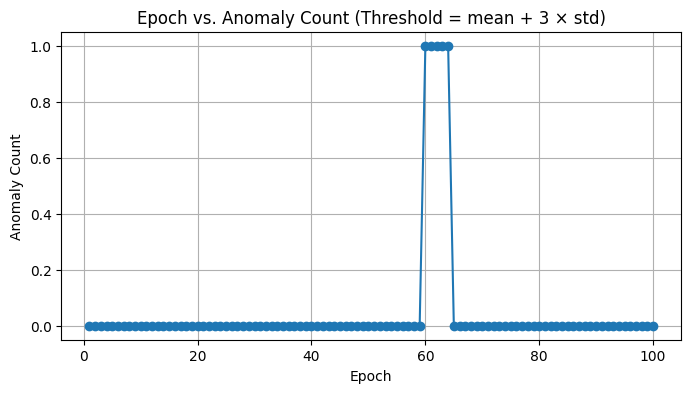

347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
전체 데이터의 평균 재구성 오차: 0.11349825068508862
최종 임계치: 0.3336428704486248
이상 데이터 갯수: 0


In [8]:
# 7. 모델 학습 (정상 데이터만 사용)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
anomaly_callback = AnomalyCountCallback(X)

history = autoencoder.fit(X, X, 
                          epochs=100,
                          batch_size=32,
                          validation_split=0.2,
                          callbacks=[es, anomaly_callback],
                          verbose=1)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Autoencoder Training Loss')
plt.show()

# 학습 완료 후 에포크별 임계치를 넘은 데이터 갯수 시각화
plt.figure(figsize=(8,4))
plt.plot(range(1, len(anomaly_callback.epoch_anomaly_counts) + 1), 
         anomaly_callback.epoch_anomaly_counts, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Anomaly Count')
plt.title('Epoch vs. Anomaly Count (Threshold = mean + 3 × std)')
plt.grid(True)
plt.show()

# 최종 모델로 전체 데이터에 대한 재구성 오차 및 최종 임계치 계산
X_pred = autoencoder.predict(X)
reconstruction_errors = np.mean(np.square(X_pred - X), axis=(1,2))
final_threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
final_anomaly_count = np.sum(reconstruction_errors > final_threshold)
print("전체 데이터의 평균 재구성 오차:", np.mean(reconstruction_errors))
print("최종 임계치:", final_threshold)
print("이상 데이터 갯수:", final_anomaly_count)

In [ ]:
# # 8. 학습 후 최종 모델 평가 시, 전체 데이터에 대한 재구성 오차와 임계치를 계산
# X_pred = autoencoder.predict(X)
# reconstruction_errors = np.mean(np.square(X_pred - X), axis=(1,2))
# final_threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
# print("최종 임계치:", final_threshold)

# # 모델 저장
# autoencoder.save('autoencoder_model.h5')

# # 임계치 저장
# with open('threshold.pkl', 'wb') as f:
#     pickle.dump(final_threshold, f)

# # LabelEncoder 저장
# with open('event_type_encoder.pkl', 'wb') as f:
#     pickle.dump(le_event, f)

# with open('hub_type_encoder.pkl', 'wb') as f:
#     pickle.dump(le_hub, f)
    
# # MinMaxScaler 저장
# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


최종 임계치: 0.3336428704486248
